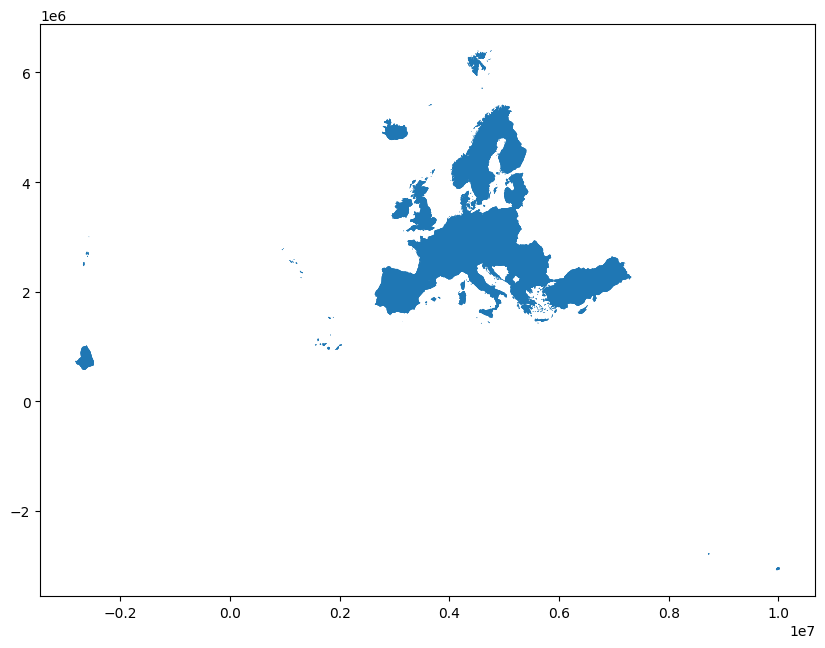

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Download the shapefile for Europe
path = "C:\\Users\\Juliu\\Downloads\\NUTS_RG_20M_2021_3035.shp\\NUTS_RG_20M_2021_3035.shp"
europe = gpd.read_file(path)

# only 

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
europe.plot(ax=ax)
plt.show()

For som reason Bosnia Herzigovina and Kosovo are missing

In [2]:
europe

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,FR,0,FR,France,France,0.0,0,0,FR,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961..."
1,HR,0,HR,Hrvatska,Hrvatska,0.0,0,0,HR,"MULTIPOLYGON (((4827385.889 2618351.326, 48483..."
2,HU,0,HU,Magyarország,Magyarország,0.0,0,0,HU,"POLYGON ((5214660.069 2880853.832, 5216710.220..."
3,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"POLYGON ((5129579.170 2204098.752, 5148385.473..."
4,AT,0,AT,Österreich,Österreich,0.0,0,0,AT,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
...,...,...,...,...,...,...,...,...,...,...
2005,TRC21,3,TR,Şanlıurfa,Şanlıurfa,4.0,2,3,TRC21,"POLYGON ((6904684.585 2120354.802, 6938677.828..."
2006,TRC22,3,TR,Diyarbakır,Diyarbakır,4.0,2,3,TRC22,"POLYGON ((6989716.599 2273670.524, 6982786.486..."
2007,NO0B2,3,NO,Svalbard,Svalbard,3.0,3,1,NO0B2,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."
2008,NO0B,2,NO,Jan Mayen and Svalbard,Jan Mayen and Svalbard,NaN,0,0,NO0B,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."


In [3]:
# exlude french overseas territories as they only have limited coverage
overseas = ["FRY10", "FRY20", "FRY30", "FRY40", "FRY50"]
europe = europe[~europe["NUTS_ID"].isin(overseas)]

In [4]:
european_regions = europe[europe["LEVL_CODE"]==3]

<Axes: >

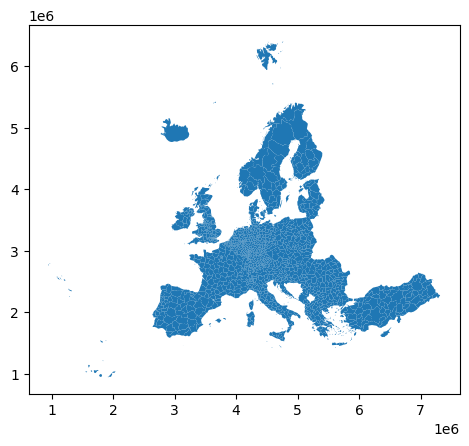

In [5]:
european_regions.plot()

In [6]:
european_regions = european_regions.dissolve()

In [7]:
import shapely
from shapely.geometry import Point, Polygon, box
from matplotlib import pyplot as plt
import numpy as np
import pickle
import contextily as ctx

In [8]:
from tqdm import tqdm

In [9]:
# xmin, ymin, xmax, ymax = european_regions.total_bounds

# length = 50000
# wide = 50000

# cols = list(np.arange(xmin, xmax + wide, wide))
# rows = list(np.arange(ymin, ymax + length, length))

# polygons = []
# for x in tqdm(cols[:-1]):
#     for y in rows[:-1]:
#         polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

In [10]:
# grid = gpd.GeoDataFrame({'geometry':polygons}, crs=european_regions.crs)

In [11]:
# europe_grid = gpd.sjoin(grid, europe, how='inner', predicate='intersects')

In [12]:
# # remove duplicate gemoetries
# europe_grid = europe_grid.drop_duplicates(subset=['geometry'])

In [13]:
# europe_grid.to_file("shapefiles/50k/europe_grid_50k.shp")

In [14]:
# load the shapefile
europe_grid = gpd.read_file("shapefiles/50k/europe_grid_50k.shp")

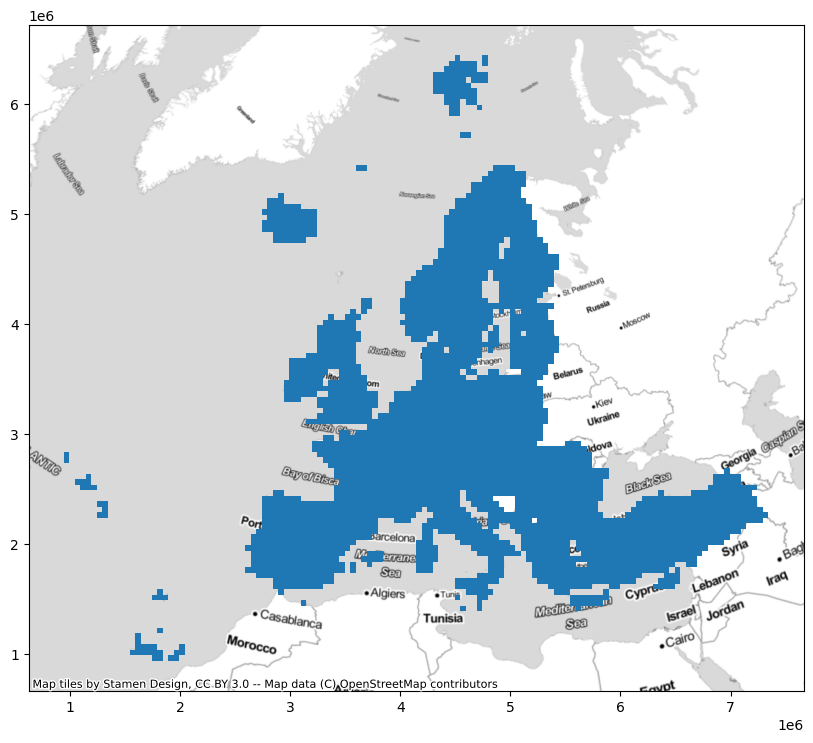

In [15]:
# plot europegrid with a basemap
fig, ax = plt.subplots(figsize=(10, 10))
europe_grid.plot(ax=ax)
ctx.add_basemap(ax, crs=europe_grid.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
plt.show()

In [16]:
europe_grid.reset_index(inplace=True)

In [17]:
def random_point(polygon):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform(minx, maxx)
    y = np.random.uniform(miny, maxy)
    return Point(x, y)

In [18]:
# create an empty list to store the random points
points = []
cntr_codes = []
grids = []
num_points = 20

# loop through each geometry in the dataframe
for index, row in europe_grid.iterrows():
    for i in range(num_points):
        # generate a random point within the geometry
        point = random_point(row['geometry'])
        # add the point to the list
        points.append(point)
        cntr_codes.append(row['CNTR_CODE'])
        grids.append(index)

# create a new geopandas dataframe with the random points
points_gdf = gpd.GeoDataFrame(geometry=points, crs=europe_grid.crs)
points_gdf['CNTR_CODE_POINT'] = cntr_codes
points_gdf['GRID_ID'] = grids

In [19]:
# # convert to real world coordinates
points_gdf_wgs84 = points_gdf.to_crs(epsg=4326)

In [20]:
points_gdf_wgs84.head()

,geometry,CNTR_CODE_POINT,GRID_ID
0,POINT (-30.98265 39.70047),PT,0
1,POINT (-31.09398 39.35726),PT,0
2,POINT (-31.02946 39.38772),PT,0
3,POINT (-30.76546 39.43196),PT,0
4,POINT (-30.94101 39.66820),PT,0


In [21]:
points_gdf_wgs84.shape

(61120, 3)

In [22]:
points_gdf_wgs84.to_file("shapefiles/50k/europe_grid_50k_points.shp")

C:\Users\Juliu\AppData\Local\Temp\ipykernel_22048\1635960948.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points_gdf_wgs84.to_file("shapefiles/50k/europe_grid_50k_points.shp")


In [23]:
# load the points
points_gdf_wgs84 = gpd.read_file("shapefiles/50k/europe_grid_50k_points.shp")

In [24]:
points_gdf_wgs84.head()

,CNTR_CODE_,GRID_ID,geometry
0,PT,0,POINT (-30.98265 39.70047)
1,PT,0,POINT (-31.09398 39.35726)
2,PT,0,POINT (-31.02946 39.38772)
3,PT,0,POINT (-30.76546 39.43196)
4,PT,0,POINT (-30.94101 39.66820)


In [25]:
# filter out points that are not actually in any of the european regions
# change the crs to the same as the points
european_regions = european_regions.to_crs(epsg=4326)
points_gdf_wgs84 = gpd.sjoin(points_gdf_wgs84, european_regions, how='left', predicate='intersects')
points_gdf_wgs84 = gpd.GeoDataFrame(points_gdf_wgs84[['geometry', 'CNTR_CODE_', 'GRID_ID']])
points_gdf_wgs84 = points_gdf_wgs84.reset_index(drop=True)

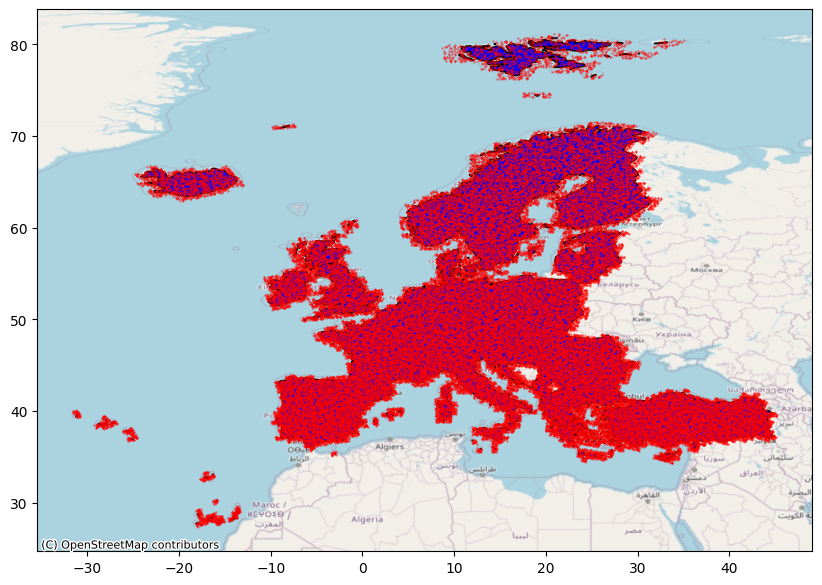

In [26]:
# plot the points with basemap
fig, ax = plt.subplots(figsize=(10, 10))
european_regions.plot(ax=ax, color='blue', edgecolor='black')
points_gdf_wgs84.plot(ax=ax, color='red', markersize=0.1)
ctx.add_basemap(ax, crs=points_gdf_wgs84.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

In [27]:
# coordinates are in lon/lat format in our dataframe

In [28]:
# need function to call google api and scrape images from coordinates

In [29]:
import os
import requests
import cv2

In [30]:
api_key = os.environ.get('GOOGLEAPI')

def run(lat, lon, radius, output_dir):
    url = 'https://maps.googleapis.com/maps/api/streetview'
    params = {'location': f'{lat},{lon}', 'key': api_key, 'radius': radius}

    location = f'{lat},{lon}'   
    size = '640x640' #i have tried increasing this, but it does not seem to make a difference
    fov = '90' 

    file_name_pano = os.path.normpath(f'{output_dir}/panos/{location}.jpg')

    # check for metadata
    metadata_url = url + '/metadata?'
    metadata_response = requests.get(metadata_url, params=params)
    metadata = metadata_response.json()
    if metadata['status'] != 'OK' or "Google" not in metadata['copyright']:
        return -1

    num_rotations = 4
    rotation_angle = 360 / num_rotations

    pano_images = []
    for i in range(num_rotations):
        heading = str(i * rotation_angle)
        params = {'size': size, 'location': location, 'fov': fov, 'heading': heading, 'key': api_key}

        response = requests.get(url, params=params)

        image = np.asarray(bytearray(response.content), dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        pano_images.append(image)
        file_name_singles = os.path.normpath(f'{output_dir}/singles/{location}_{heading}.jpg')
        try:
            cv2.imwrite(file_name_singles, image)
        except:
            print("saving image failed")

    
    pano_stitch = np.concatenate((pano_images), axis=1)

    cv2.imwrite(file_name_pano, pano_stitch)

    return 0

In [31]:
def meta_data_test(lat, lon, radius=1000):
    url = 'https://maps.googleapis.com/maps/api/streetview/metadata?'
    params = {'location': f'{lat},{lon}', 'key': api_key, 'radius': radius}
    response = requests.get(url, params=params)
    metadata = response.json()
    if metadata['status'] != 'OK' or "Google" not in metadata['copyright']:
        return -1
    else:
        return 0

In [32]:
results = []

for point in tqdm(points_gdf_wgs84.iloc[10000:15000]['geometry']):
    lat = point.y
    lon = point.x
    result = meta_data_test(lat, lon)
    results.append(result)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [20:05<00:00,  4.15it/s]


In [ ]:
for point in tqdm(points_gdf_wgs84):
    lat = point['geometry'].y
    lon = point['geometry'].x
    cntr_code = point['CNTR_CODE_']
    grid_id = point['GRID_ID']
    result = run(lat, lon, 1000, f'images/{cntr_code}/{grid_id}')
    results.append(result)
    
